# Electricity consumption profiling

In [1]:
import calendar
import datetime as dt
from typing import Tuple

import lightgbm as lgb
import matplotlib.cm as mcm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

RANDOM_SEED = 42

In [2]:
# You might need to install pyarrow for loading the dataset from the compressed parquet file
# ! pip install pyarrow

In [3]:
# Load input data
input_data = pd.read_parquet("normalized_consumption.parquet.gzip")
input_data = input_data.assign(usage=input_data["usage"] * 48 * 365)
clusters = pd.read_csv("clusters.csv")
calendar_data = pd.read_csv("special_day_calendar.csv").astype(
    dict(date="datetime64[ns]")
)[["date", "day_type_id"]]

In [4]:
display(input_data.sample(5))
display(clusters.sample(5))

meter_id           timestamp     usage
331593       199 2011-12-12 06:30:00  0.524232
68558        581 2013-08-05 01:00:00  0.530068
302110        62 2012-12-07 06:00:00  1.047081
792043       581 2013-02-05 15:30:00  0.939143
924034        40 2012-02-11 18:30:00  1.213668

meter_id  cluster_name
0        40             4
3       294             5
8       570             0
5       436             2
4       330             4

## Single cluster example
### Feature extraction, train/test splitting

In [5]:
# Select all meters in cluster 1
cluster_meters = clusters.loc[clusters["cluster_name"] == 1, "meter_id"]
cluster_data = input_data.loc[input_data["meter_id"].isin(cluster_meters)]

In [6]:
# ML feature pipeline
def processing_pipeline(
    df: pd.DataFrame,
    cal_data: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = df.reset_index(drop=True)

    # Circular encoding for the fractional year (day of year divided by number of days in year)
    doy = df.timestamp.dt.dayofyear
    year_days = df.timestamp.dt.year.apply(lambda x: 366 if calendar.isleap(x) else 365)
    df["year_sin"] = np.sin(2 * np.pi * doy / year_days)
    df["year_cos"] = np.cos(2 * np.pi * doy / year_days)
    df["day_sin"] = np.sin(
        2 * np.pi * (df.timestamp.dt.hour + df.timestamp.dt.minute / 60) / 24
    )
    df["day_cos"] = np.cos(
        2 * np.pi * (df.timestamp.dt.hour + df.timestamp.dt.minute / 60) / 24
    )

    # One hot encoding for weekdays, with a special class for holidays
    df["weekday"] = df.timestamp.dt.weekday
    df = df.merge(
        cal_data,
        left_on=df["timestamp"].dt.date,
        right_on=cal_data["date"].dt.date,
        how="left",
    )
    df.loc[~df["day_type_id"].isna(), "weekday"] = 99
    df = df.drop(columns=["date", "day_type_id", "key_0"])

    enc = OneHotEncoder()
    enc.fit(df["weekday"].values.reshape(-1, 1))
    data = enc.transform(df["weekday"].values.reshape(-1, 1)).toarray()
    weekdaycols = enc.get_feature_names(["weekday"])
    df = df.reindex(columns=df.columns.tolist() + list(weekdaycols))
    df[weekdaycols] = data
    if "weekday_99" not in df.columns:
        df = df.assign(
            weekday_99=0,
        )
    df = df.dropna()
    df = df.drop(columns=["meter_id", "timestamp", "weekday"])

    # Return features and labels separately
    return df[[i for i in df.columns if "usage" not in i]], df["usage"]

In [7]:
# Split into training and validation sets, send these through pipeline
# It would be nice to do a chronological split here, but this would make for a bad model if there's only
# ~ 1 year of data provided so for now we're just using a random split.
train_data, valid_data = train_test_split(cluster_data, random_state=RANDOM_SEED)
x_train, y_train = processing_pipeline(
    train_data,
    calendar_data,
)
x_valid, y_valid = processing_pipeline(
    valid_data,
    calendar_data,
)

In [8]:
# This is what our features look like
x_train.sample(5)

year_sin  year_cos   day_sin   day_cos  weekday_0  weekday_1  \
47907 -0.463550  0.886071  0.923880  0.382683        0.0        1.0   
62865 -0.213521 -0.976938 -0.793353  0.608761        0.0        0.0   
30403  0.995546  0.094279 -0.991445  0.130526        1.0        0.0   
45332  0.329408 -0.944188  0.707107 -0.707107        0.0        0.0   
48222 -0.471160 -0.882048 -0.793353 -0.608761        0.0        1.0   

       weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  weekday_99  
47907        0.0        0.0        0.0        0.0        0.0         0.0  
62865        0.0        0.0        0.0        0.0        1.0         0.0  
30403        0.0        0.0        0.0        0.0        0.0         0.0  
45332        1.0        0.0        0.0        0.0        0.0         0.0  
48222        0.0        0.0        0.0        0.0        0.0         0.0

In [9]:
# And these are the labels - normalized half-hourly consumption
y_train.sample(5)

21339    0.306474
47801    0.672048
71297    1.274286
22568    0.895227
42144    0.457285
Name: usage, dtype: float64

In [10]:
# To get an idea of the dataset size
len(x_train), len(x_valid)

(79018, 26340)

### LGB model

In [11]:
# Create simple LGBM model with pretty standard settings
def fit_model(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_valid: pd.DataFrame,
    y_valid: pd.DataFrame,
) -> lgb.Booster:
    params = dict(
        seed=RANDOM_SEED,
        objective="regression",
        metric="l1",
        verbosity=-1,
        boosting_type="gbdt",
    )

    d_train = lgb.Dataset(x_train, label=y_train)
    d_valid = lgb.Dataset(x_valid, label=y_valid)

    model = lgb.train(
        params,
        train_set=d_train,
        num_boost_round=50000,
        valid_sets=[d_valid],
        verbose_eval=10,
        early_stopping_rounds=10,
    )
    return model

In [12]:
# Simple function for predicting half-hourly consumption for a set of timestamps
def predict_dates(
    dates: pd.Series,
    model: lgb.Booster,
    cal_data: pd.DataFrame,
):
    # Note we need to assign usage=0 here for the processing pipeline to work, but we discard
    # the label output (which is all zeros)
    tmp = pd.DataFrame().assign(
        timestamp=dates,
        meter_id="inference",
        usage=0,
    )
    x_gen, _ = processing_pipeline(tmp, cal_data)
    return model.predict(x_gen, num_iteration=model.best_iteration)

### Train and explore model

In [13]:
# Train
model = fit_model(x_train, y_train, x_valid, y_valid)

# Predict for input period so we can calculate stats later
cluster_profiles = cluster_data[["meter_id", "timestamp", "usage"]].pivot_table(
    index="timestamp", columns="meter_id", values="usage"
)
cluster_profiles = cluster_profiles.assign(
    model=predict_dates(cluster_profiles.index, model, calendar_data)
)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's l1: 0.422678
[20]	valid_0's l1: 0.404955
[30]	valid_0's l1: 0.401052
[40]	valid_0's l1: 0.399478
[50]	valid_0's l1: 0.398607
[60]	valid_0's l1: 0.398213
[70]	valid_0's l1: 0.397706
[80]	valid_0's l1: 0.397432
[90]	valid_0's l1: 0.397227
[100]	valid_0's l1: 0.397037
[110]	valid_0's l1: 0.396904
[120]	valid_0's l1: 0.396697
[130]	valid_0's l1: 0.396372
[140]	valid_0's l1: 0.396178
[150]	valid_0's l1: 0.39615
[160]	valid_0's l1: 0.395927
[170]	valid_0's l1: 0.395765
[180]	valid_0's l1: 0.395498
[190]	valid_0's l1: 0.395373
[200]	valid_0's l1: 0.395308
[210]	valid_0's l1: 0.395164
[220]	valid_0's l1: 0.395054
[230]	valid_0's l1: 0.394938
[240]	valid_0's l1: 0.394944
[250]	valid_0's l1: 0.394731
[260]	valid_0's l1: 0.394544
[270]	valid_0's l1: 0.394428
[280]	valid_0's l1: 0.394356
[290]	valid_0's l1: 0.394362
Early stopping, best iteration is:
[284]	valid_0's l1: 0.394303


In [14]:
cluster_profiles.sample(5)

meter_id                  199       581       697     model
timestamp                                                  
2012-08-21 19:30:00  1.193635  1.146561  0.616531  1.461221
2013-06-19 00:30:00  0.588753  0.501260  0.376931  0.527973
2013-02-07 20:30:00  1.104919  1.457688  1.608531  1.786622
2012-08-16 01:00:00  0.387125  0.518545  0.543482  0.521739
2013-05-18 09:00:00  0.306474  1.175369  0.591694  0.916631

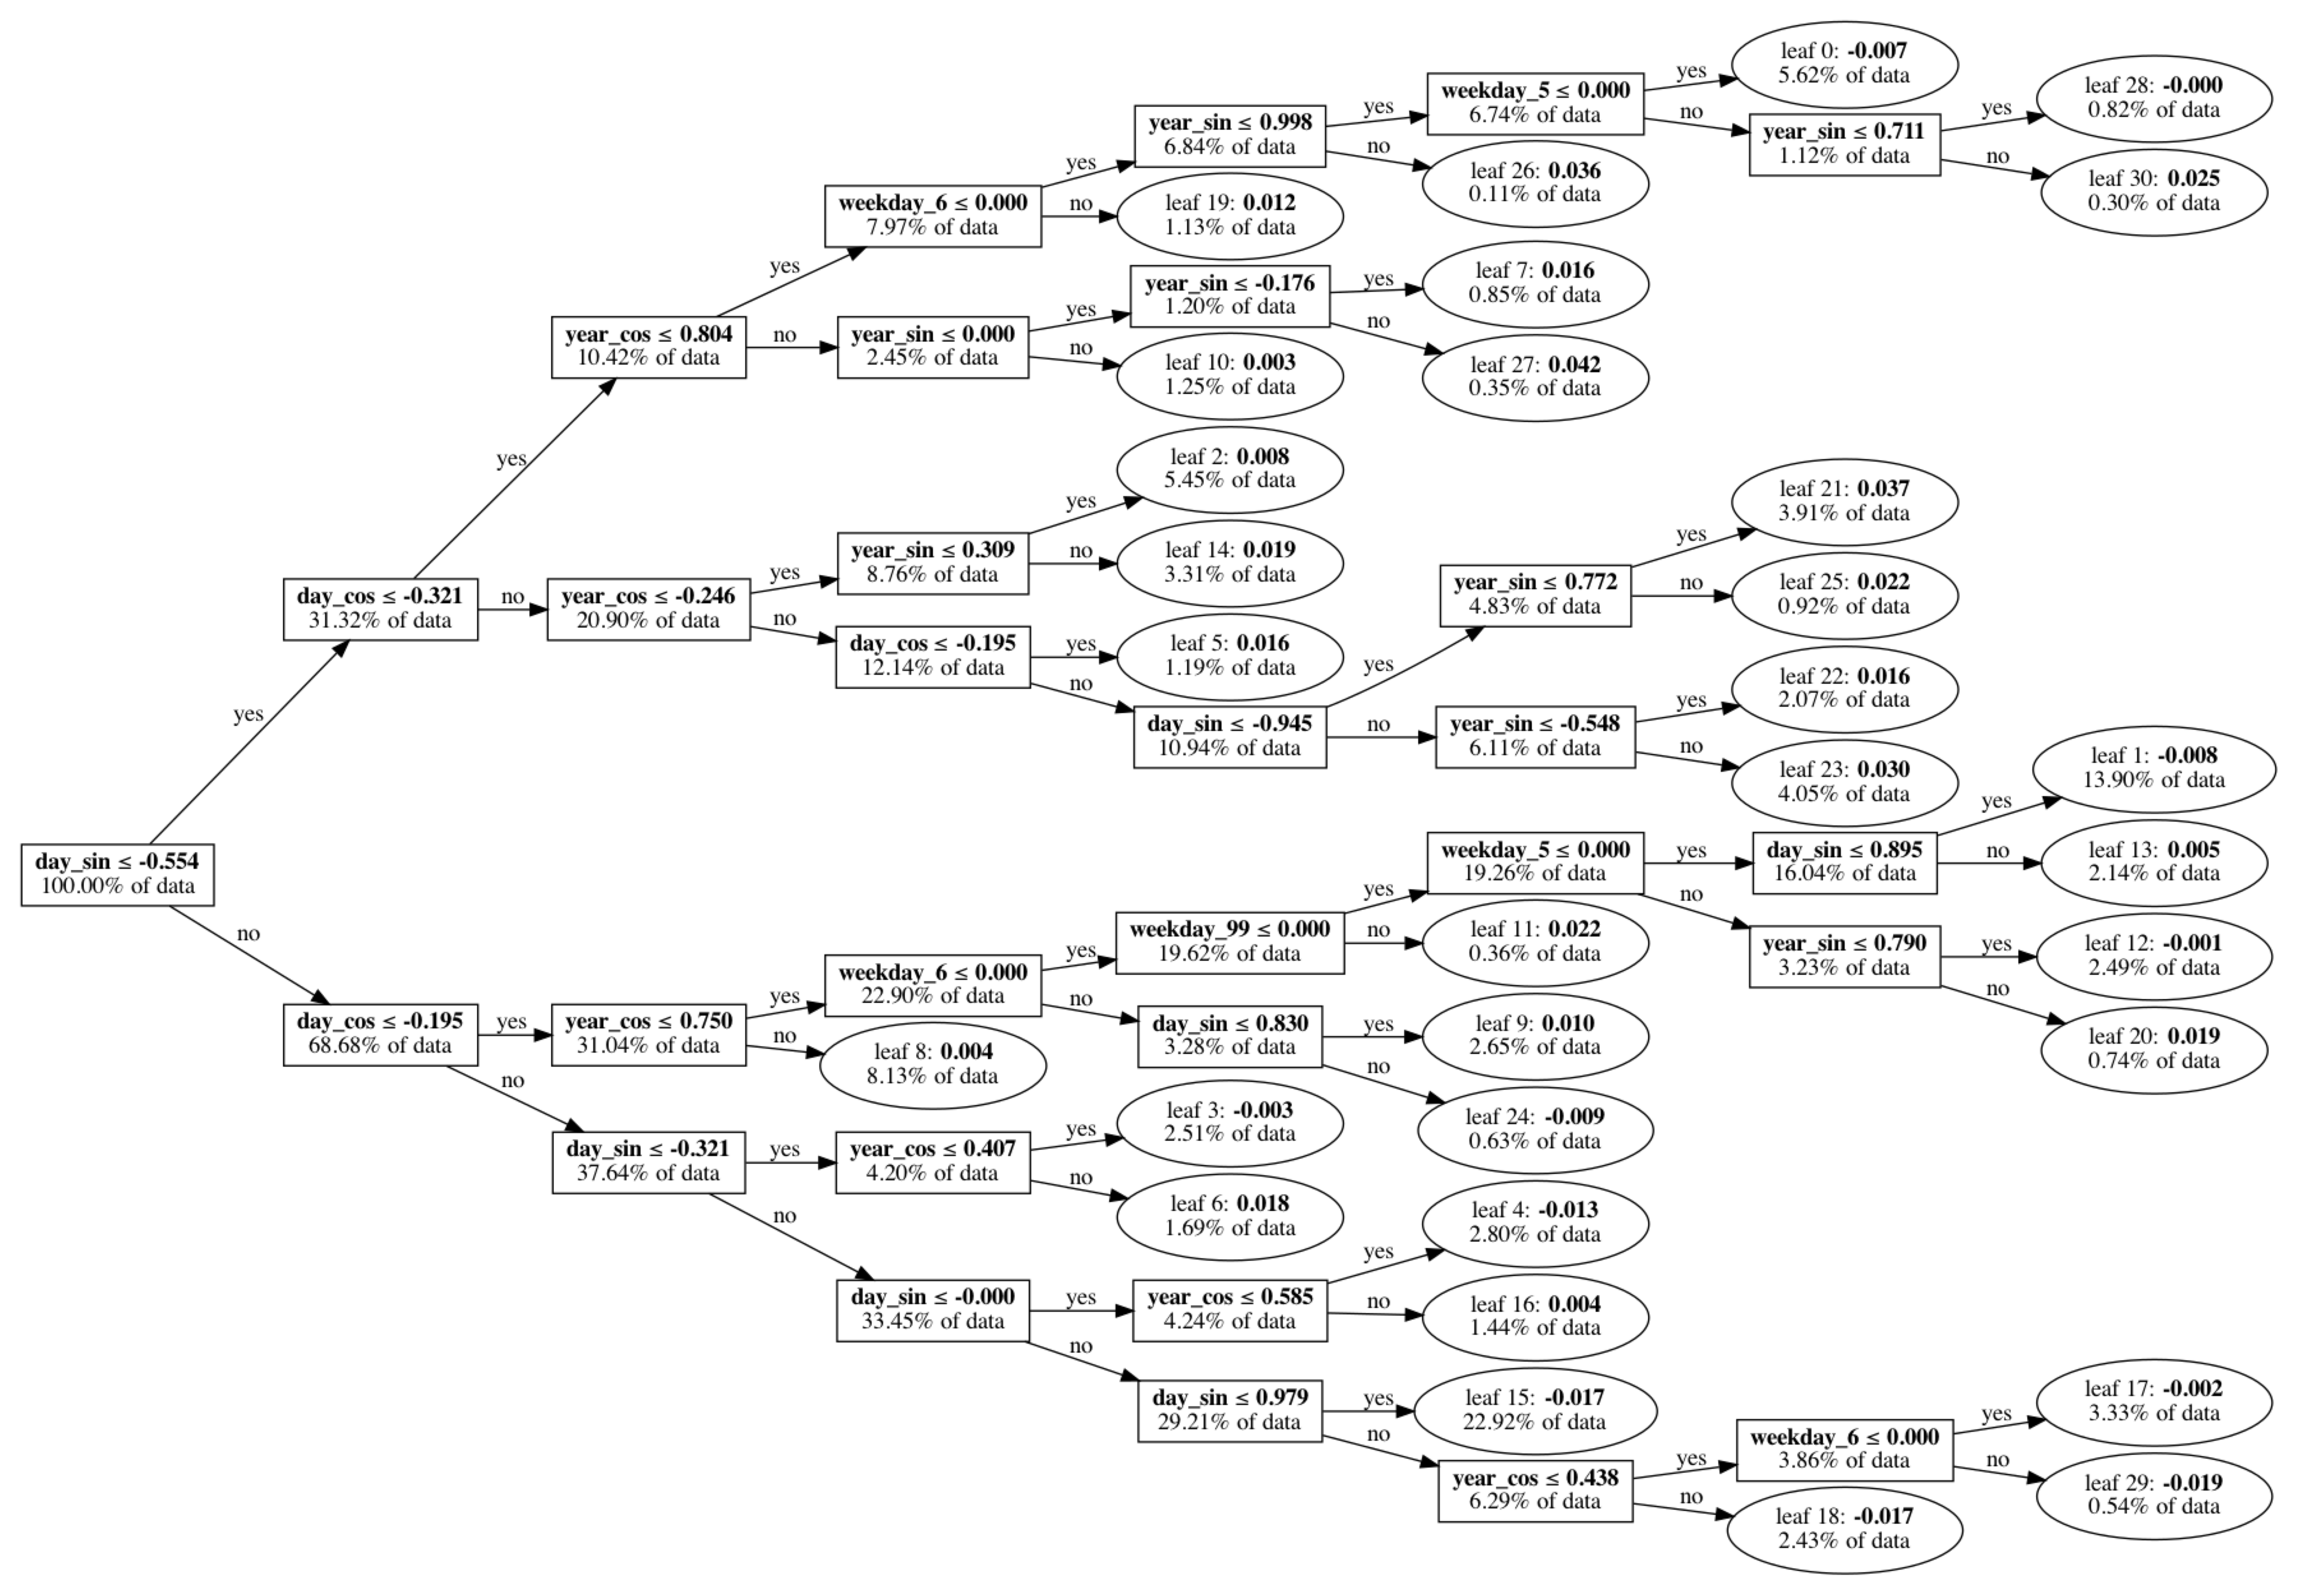

In [15]:
lgb.plot_tree(
    model, tree_index=10, figsize=(21, 14), dpi=300, show_info="data_percentage"
)
plt.savefig("fig_lgb_tree.png", bbox_inches="tight")

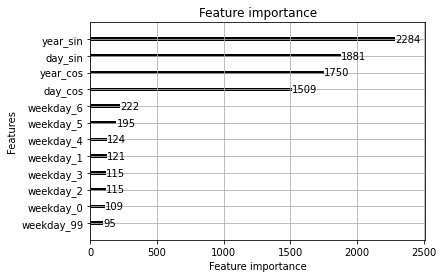

In [16]:
lgb.plot_importance(model, color="k")
plt.savefig("fig_lgb_importance.png", bbox_inches="tight", dpi=300)

## Train for more clusters, check out results

In [17]:
# This function combines all the steps laid out previously
# It picks all data belonging to one cluster, trains a model and creates a prediction
# Not super clean since this function uses some global variables, but will do for demo purposes
input_profiles = input_data[["meter_id", "timestamp", "usage"]].pivot_table(
    index="timestamp", columns="meter_id", values="usage"
)


def train_for_cluster(cluster_name: int, exclude_meter: bool = False):

    # Select all meters in this cluster, apart from one of them if `exlude_meter` == True
    cluster_meters = clusters.loc[clusters["cluster_name"] == cluster_name, "meter_id"]
    cluster_data = input_data[input_data["meter_id"].isin(cluster_meters)]
    if exclude_meter and len(cluster_meters) > 1:
        validation_meter = cluster_meters.iloc[0]
        cluster_data = cluster_data[cluster_data["meter_id"] != validation_meter]
    else:
        validation_meter = None

    # Train/test split, feature extraction
    train_data, valid_data = train_test_split(cluster_data, random_state=RANDOM_SEED)
    x_train, y_train = processing_pipeline(
        train_data,
        calendar_data,
    )
    x_valid, y_valid = processing_pipeline(
        valid_data,
        calendar_data,
    )

    # Train
    model = fit_model(x_train, y_train, x_valid, y_valid)

    # Predict for same period
    cluster_profiles = input_profiles[cluster_meters].assign(
        model=predict_dates(input_profiles.index, model, calendar_data)
    )
    if validation_meter:
        cluster_profiles = cluster_profiles.rename(
            columns={validation_meter: str(validation_meter) + "_val"}
        )

    return cluster_profiles

In [18]:
all_clusters = clusters["cluster_name"].unique()
all_results = {}
for cluster_id in all_clusters:
    all_results[str(cluster_id)] = train_for_cluster(cluster_id, exclude_meter=True)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's l1: 0.323198
[20]	valid_0's l1: 0.316603
[30]	valid_0's l1: 0.315253
[40]	valid_0's l1: 0.314706
[50]	valid_0's l1: 0.314265
[60]	valid_0's l1: 0.31396
[70]	valid_0's l1: 0.313747
[80]	valid_0's l1: 0.313602
[90]	valid_0's l1: 0.313458
[100]	valid_0's l1: 0.313292
[110]	valid_0's l1: 0.313155
[120]	valid_0's l1: 0.313033
[130]	valid_0's l1: 0.312844
[140]	valid_0's l1: 0.312862
[150]	valid_0's l1: 0.312756
[160]	valid_0's l1: 0.312802
Early stopping, best iteration is:
[150]	valid_0's l1: 0.312756
Training until validation scores don't improve for 10 rounds
[10]	valid_0's l1: 0.391925
[20]	valid_0's l1: 0.369606
[30]	valid_0's l1: 0.363204
[40]	valid_0's l1: 0.360242
[50]	valid_0's l1: 0.358445
[60]	valid_0's l1: 0.357132
[70]	valid_0's l1: 0.356205
[80]	valid_0's l1: 0.355239
[90]	valid_0's l1: 0.354511
[100]	valid_0's l1: 0.353936
[110]	valid_0's l1: 0.353253
[120]	valid_0's l1: 0.352808
[130]	valid_0's l1: 0

In [19]:
# Some functions for result analysis
def calc_mape(y_actual, y_pred):
    valid = np.where((y_actual > 0) & (y_pred > 0))[0]
    y_actual = y_actual[valid]
    y_pred = y_pred[valid]
    return np.mean(np.abs((y_actual - y_pred) / ((y_actual + y_pred) / 2)))


def calc_euclidean(y_actual, y_pred):
    valid = np.where((y_actual > 0) & (y_pred > 0))[0]
    y_actual = y_actual[valid]
    y_pred = y_pred[valid]
    return np.linalg.norm(y_actual - y_pred)


def calculate_metric(metric: str, actual: pd.Series, predicted: pd.Series) -> float:
    if metric.lower() == "correlation":
        return actual.corr(predicted)
    elif metric.lower() == "mape":  # distance = MAPE
        return calc_mape(actual.values, predicted.values)
    elif metric.lower() == "euclidean":  # distance = euclidean distance
        return calc_euclidean(actual.values, predicted.values)
    else:
        raise CalculationException("Unknown metric provided.")


def smooth_curve(s: pd.Series) -> pd.Series:
    smoothed = s.resample("120min").mean()
    smoothed = smoothed.groupby(
        [smoothed.index.month, smoothed.index.weekday, smoothed.index.hour]
    ).mean()
    return smoothed

In [20]:
# Calculate metrics comparing:
# - raw consumption data to model
# - smoothed consumption data to model
result_clusters = sorted(list(all_results.keys()))
result_meter_clusters = {
    m: k for k, v in all_results.items() for m in v.columns if m != "model"
}
result_meters = list(result_meter_clusters.keys())

metrics_raw = np.zeros(
    (len(all_results.keys()), sum([len(x.columns) - 1 for x in all_results.values()]))
)
metrics_smooth = np.zeros(
    (len(all_results.keys()), sum([len(x.columns) - 1 for x in all_results.values()]))
)
for model_idx, cluster in enumerate(result_clusters):
    metric_model = all_results[cluster]["model"]
    for meter_idx, meter in enumerate(result_meters):
        metric_meter = all_results[result_meter_clusters[meter]][meter]
        metrics_raw[model_idx, meter_idx] = calculate_metric(
            "mape", metric_model, metric_meter
        )
        metrics_smooth[model_idx, meter_idx] = calculate_metric(
            "mape", smooth_curve(metric_model), smooth_curve(metric_meter)
        )

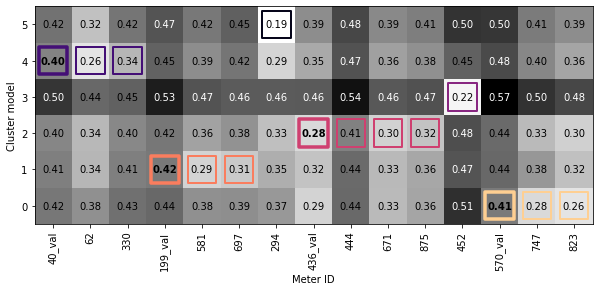

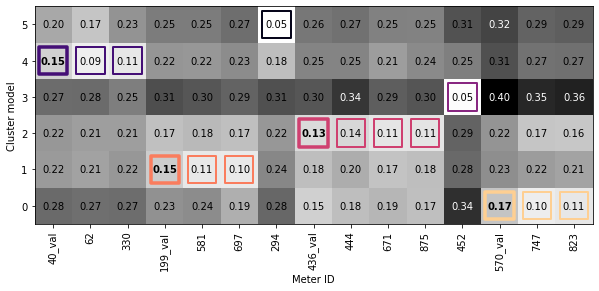

In [21]:
# Plot raw and smoothed metrics

def plot_metrics(metrics):
    cmap = mcm.get_cmap("magma_r")
    width = 10
    height = len(result_clusters) / len(result_meters) * width
    fig = plt.figure(figsize=(width, height))
    ax = plt.subplot()
    ax.pcolormesh(metrics, cmap="Greys")
    ax.set_xticks(np.arange(0.5, metrics.shape[1], 1))
    ax.set_yticks(np.arange(0.5, metrics.shape[0], 1))
    ax.set_xticklabels(result_meters, rotation=90)
    ax.set_yticklabels(result_clusters)
    ax.set_xlabel("Meter ID")
    ax.set_ylabel("Cluster model")
    for (i, j), z in np.ndenumerate(metrics.T):
        _meter = result_meters[i]
        _cluster = result_clusters[j]
        ax.text(
            i + 0.5,
            j + 0.5,
            "{:0.2f}".format(z),
            ha="center",
            va="center",
            c="k" if z < 0.8 * metrics.max() else "1",
            fontweight="bold"
            if "_val" in str(_meter) and result_meter_clusters[_meter] == _cluster
            else "normal",
        )
        if result_meter_clusters[_meter] == _cluster:
            color = cmap(0.1 + 0.17 * int(_cluster))
            box = Rectangle((i + 0.12, j + 0.12), 0.76, 0.76)
            pc = PatchCollection(
                [box],
                alpha=1,
                facecolor="none",
                linewidth=3.5 if "_val" in str(_meter) else 2,
                edgecolor=color,
            )
            plt.gca().add_collection(pc)


plot_metrics(metrics_raw)
plt.savefig("fig_metrics_raw.png", bbox_inches="tight")
plot_metrics(metrics_smooth)
plt.savefig("fig_metrics_smooth.png", bbox_inches="tight")

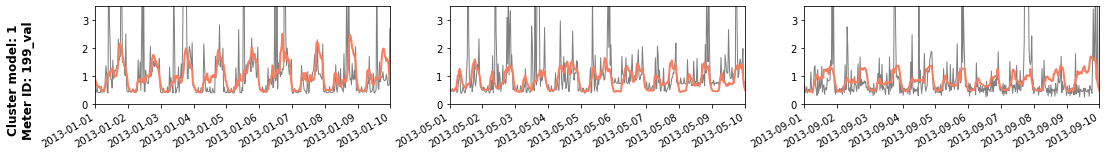

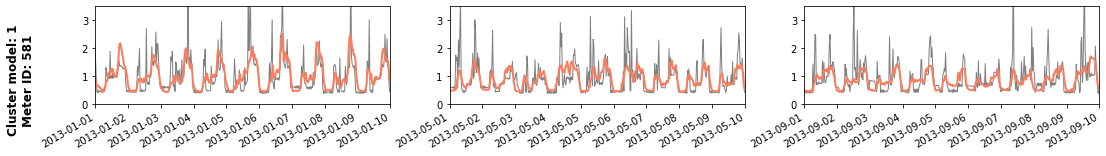

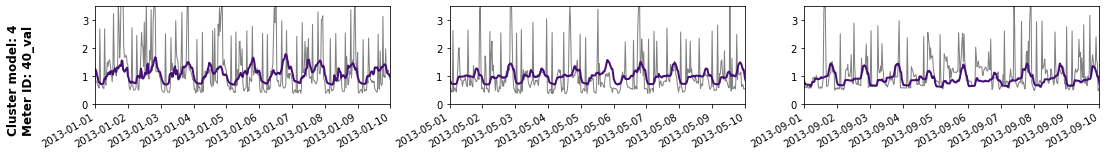

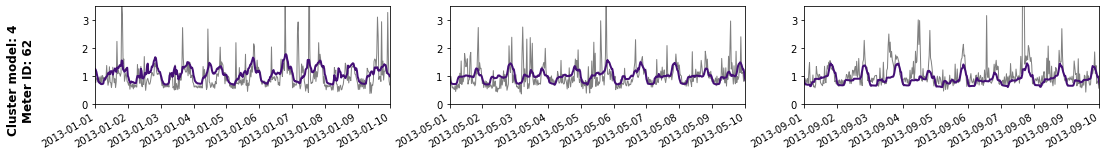

In [22]:
def plot_real_comp(model, meter, color):
    plt.plot(meter.index, meter.values, color="grey", lw=1)
    plt.plot(model.index, model.values, color=color, lw=2)
    plt.ylim([0, 3.5])


def make_comparison_plot(model, meter, cluster_name, meter_name):
    cmap = mcm.get_cmap("magma_r")
    color = cmap(0.1 + 0.17 * int(cluster_name))
    plt.figure(figsize=(18, 2))
    for subpl, month_name, month_num in zip(
        [131, 132, 133], ["Jan", "May", "Sep"], [1, 5, 9]
    ):
        ax = plt.subplot(subpl)
        plot_real_comp(model, meter, color)
        ax.set_xlim([dt.date(2013, month_num, 1), dt.date(2013, month_num, 10)])
        # ax.text(0.05, 0.9, f"1st week of {month_name} 2013", fontweight="bold", fontsize=12, transform=ax.transAxes)
        if subpl == 131:
            ax.text(
                -0.25,
                0.25,
                f"Cluster model: {cluster_name}\nMeter ID: {meter_name}",
                fontweight="bold",
                fontsize=12,
                transform=ax.transAxes,
                rotation=90,
                ha="center",
                va="center",
            )
    plt.gcf().autofmt_xdate()
    plt.show()


for cluster in result_clusters:
    if cluster not in ["1", "4"]:
        continue
    plot_model = all_results[cluster]["model"]
    for meter in all_results[cluster].columns[:2]:
        if meter == "model":
            continue
        plot_meter = all_results[cluster][meter]

        make_comparison_plot(plot_model, plot_meter, cluster, meter)

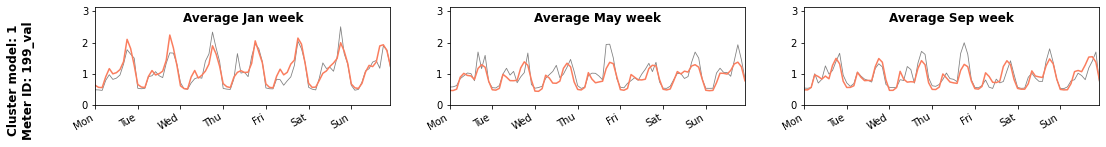

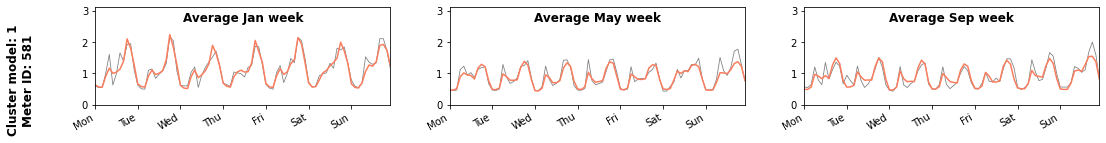

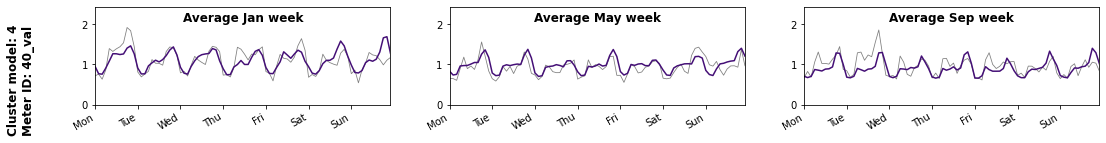

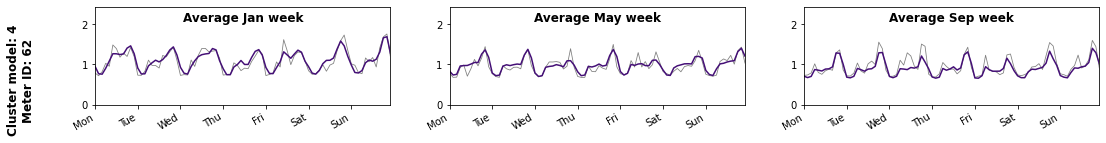

In [23]:
def plot_avg_comp(model, meter, month, color):
    plt.plot(meter.loc[month, :].values, color="grey", lw=0.8)
    plt.plot(model.loc[month, :].values, color=color, lw=1.5)
    plt.ylim([0, model.values.max() * 1.4])
    plt.xlim([0, 83])
    plt.gca().set_xticks(np.arange(0, 84, 12))
    plt.gca().set_xticklabels(calendar.day_abbr)


def make_comparison_plot(model, meter, cluster_name, meter_name):
    cmap = mcm.get_cmap("magma_r")
    color = cmap(0.1 + 0.17 * int(cluster_name))
    plt.figure(figsize=(18, 2))
    for subpl, month_name, month_num in zip(
        [131, 132, 133], ["Jan", "May", "Sep"], [1, 5, 9]
    ):
        ax = plt.subplot(subpl)
        plot_avg_comp(model, meter, month_num, color)
        ax.text(
            0.5,
            0.85,
            f"Average {month_name} week",
            fontweight="bold",
            fontsize=12,
            transform=ax.transAxes,
            ha="center",
        )
        if subpl == 131:
            ax.text(
                -0.25,
                0.25,
                f"Cluster model: {cluster_name}\nMeter ID: {meter_name}",
                fontweight="bold",
                fontsize=12,
                transform=ax.transAxes,
                rotation=90,
                ha="center",
                va="center",
            )
    plt.gcf().autofmt_xdate()
    plt.show()


for cluster in result_clusters:
    if cluster not in ["1", "4"]:
        continue
    smoothed_result = all_results[cluster].apply(smooth_curve, axis=0)
    smoothed_result.index.names = ["month", "weekday", "hour"]
    for meter in all_results[cluster].columns[:2]:
        make_comparison_plot(
            smoothed_result["model"], smoothed_result[meter], cluster, meter
        )